In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN model for CIFAR10
class CNNModel(nn.Module):
    def __init__(self, n_hidden=128, n_out=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, train_loader, test_loader, epochs=50, lr=0.001, l2_reg=1e-7):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {running_loss:.4f}")

    # Evaluate
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(batch_y)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds))
    return model


In [55]:
# 📦 Imports
import numpy as np
import os
import pickle
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 🛠️ Utility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def readCIFAR10(data_path):
    X, y = [], []
    for i in range(1, 6):
        with open(os.path.join(data_path, f'data_batch_{i}'), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            X.append(batch[b'data'])
            y.extend(batch[b'labels'])
    X = np.vstack(X)
    y = np.array(y)

    with open(os.path.join(data_path, 'test_batch'), 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        X_test = batch[b'data']
        y_test = np.array(batch[b'labels'])

    return X, y, X_test, y_test

def preprocess_cifar(X_train, X_test):
    def reshape(x):
        x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
        x = x.reshape((x.shape[0], 32, 32, 3)).transpose(0, 3, 1, 2)  # NCHW
        return x.astype(np.float32)

    X_train = reshape(X_train)
    X_test = reshape(X_test)

    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0).clip(min=1e-6)

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    return X_train, X_test

def build_dataloader(X, y, batch_size=128, shuffle=True):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def extract_attack_features(model, loader, precision=None, label_only=False, noise_std=0.0):
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs_raw = model(x)
            if label_only:
                preds = outputs_raw.argmax(dim=1).unsqueeze(1).float()
                outputs.append(preds.cpu())
            else:
                probs = F.softmax(outputs_raw, dim=1)
                if precision is not None:
                    probs = torch.round(probs * (10**precision)) / (10**precision)
                if noise_std > 0.0:
                    noise = torch.randn_like(probs) * noise_std
                    probs = probs + noise
                    probs = torch.clamp(probs, 0, 1)  # ensure still valid prob distribution
                    probs = probs / probs.sum(dim=1, keepdim=True)  # re-normalize
                outputs.append(probs.cpu())
            labels.append(y)
    return torch.cat(outputs).numpy(), torch.cat(labels).numpy()




# ✨ GENERATE DATA FOR ATTACK
def prepare_attack_data(precision=None, label_only=False, noise_std=0.0):
    path = '/kaggle/input/cifar-10-batches-py'  # or your CIFAR path
    X, y, X_test, y_test = readCIFAR10(path)
    X, X_test = preprocess_cifar(X, X_test)

    cluster = 10520
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X_target_train, y_target_train = X[:cluster], y[:cluster]
    X_shadow_train, y_shadow_train = X[cluster:2*cluster], y[cluster:2*cluster]
    X_target_test, y_target_test = X[2*cluster:3*cluster], y[2*cluster:3*cluster]
    X_shadow_test, y_shadow_test = X[3*cluster:4*cluster], y[3*cluster:4*cluster]

    print("\nTraining Target Model...")
    target_model = CNNModel().to(device)
    target_model = train_model(target_model,
                               build_dataloader(X_target_train, y_target_train),
                               build_dataloader(X_target_test, y_target_test, shuffle=False),
                               epochs=75)

    print("\nTraining Shadow Model...")
    shadow_model = CNNModel().to(device)
    shadow_model = train_model(shadow_model,
                               build_dataloader(X_shadow_train, y_shadow_train),
                               build_dataloader(X_shadow_test, y_shadow_test, shuffle=False),
                               epochs=75)

    # Extract attack data
    target_train_loader = build_dataloader(X_target_train, y_target_train)
    target_test_loader = build_dataloader(X_target_test, y_target_test, shuffle=False)
    shadow_train_loader = build_dataloader(X_shadow_train, y_shadow_train)
    shadow_test_loader = build_dataloader(X_shadow_test, y_shadow_test, shuffle=False)

    attack_train_X, attack_train_Y = extract_attack_features(shadow_model, shadow_train_loader, precision=precision, label_only=label_only, noise_std=noise_std)
    attack_train_X_test, attack_train_Y_test = extract_attack_features(shadow_model, shadow_test_loader, precision=precision, label_only=label_only, noise_std=noise_std)
    attack_test_X, attack_test_Y = extract_attack_features(target_model, target_train_loader, precision=precision, label_only=label_only, noise_std=noise_std)
    attack_test_X_test, attack_test_Y_test = extract_attack_features(target_model, target_test_loader, precision=precision, label_only=label_only, noise_std=noise_std)
    
    final_attack_train_X = np.vstack((attack_train_X, attack_train_X_test))
    final_attack_train_Y = np.hstack((np.ones(len(attack_train_X)), np.zeros(len(attack_train_X_test))))

    final_attack_test_X = np.vstack((attack_test_X, attack_test_X_test))
    final_attack_test_Y = np.hstack((np.ones(len(attack_test_X)), np.zeros(len(attack_test_X_test))))

    return final_attack_train_X, final_attack_train_Y, final_attack_test_X, final_attack_test_Y


   

In [56]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# 🛠️ Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AttackModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def build_attack_loader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                             torch.tensor(y, dtype=torch.long))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def train_attack_model(train_loader, input_dim, epochs=100):
    model = AttackModel(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    prev_totalloss=1000
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 5 == 0:
            print(f"Epoch {epoch} Loss: {total_loss:.4f}")
            # if prev_totalloss-total_loss<1 :
            #     break
        prev_totalloss=total_loss
    return model
    
def evaluate_attack_model(model, test_loader, return_metrics=False):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            preds = torch.softmax(preds, dim=1)[:,1]
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    auc = roc_auc_score(all_labels, all_preds)

    print(f"Attack Model Accuracy: {acc:.4f}")
    print(f"Attack Model AUC: {auc:.4f}")

    if return_metrics:
        return acc, auc



======== Running for noise_std: 0.0 ========

Training Target Model...
Epoch 0, Train Loss: 145.2133
Epoch 10, Train Loss: 30.7431
Epoch 20, Train Loss: 1.5740
Epoch 30, Train Loss: 0.4377
Epoch 40, Train Loss: 0.1986
Epoch 50, Train Loss: 0.1051
Epoch 60, Train Loss: 0.0607
Epoch 70, Train Loss: 0.0366
Test Accuracy: 0.6221
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1039
           1       0.75      0.73      0.74      1100
           2       0.49      0.51      0.50      1041
           3       0.46      0.45      0.45      1029
           4       0.58      0.53      0.55      1083
           5       0.53      0.48      0.50      1031
           6       0.67      0.72      0.70      1073
           7       0.65      0.68      0.67      1049
           8       0.73      0.74      0.73      1025
           9       0.68      0.71      0.70      1050

    accuracy                           0.62     10520
   macro avg       0.6

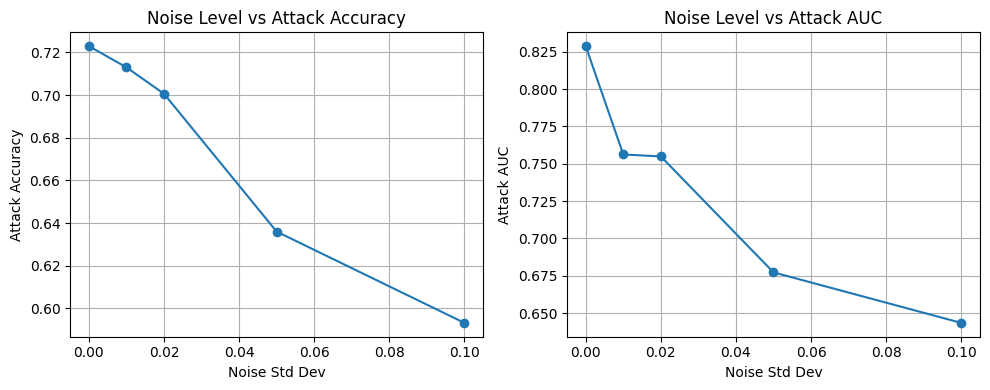

In [57]:
import matplotlib.pyplot as plt

noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1]
attack_accuracies = []
attack_aucs = []

for noise_std in noise_levels:
    print(f"\n======== Running for noise_std: {noise_std} ========")
    attack_train_X, attack_train_Y, attack_test_X, attack_test_Y = prepare_attack_data(noise_std=noise_std)
    attack_train_loader = build_attack_loader(attack_train_X, attack_train_Y)
    attack_test_loader = build_attack_loader(attack_test_X, attack_test_Y, shuffle=False)

    attack_model = train_attack_model(attack_train_loader, input_dim=attack_train_X.shape[1], epochs=30)
    model_acc, model_auc = evaluate_attack_model(attack_model, attack_test_loader, return_metrics=True)

    attack_accuracies.append(model_acc)
    attack_aucs.append(model_auc)

# 📈 Plotting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(noise_levels, attack_accuracies, marker='o')
plt.title("Noise Level vs Attack Accuracy")
plt.xlabel("Noise Std Dev")
plt.ylabel("Attack Accuracy")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(noise_levels, attack_aucs, marker='o')
plt.title("Noise Level vs Attack AUC")
plt.xlabel("Noise Std Dev")
plt.ylabel("Attack AUC")
plt.grid(True)

plt.tight_layout()
plt.show()



======== Running Full Softmax Attack ========

Training Target Model...
Epoch 0, Train Loss: 145.2055
Epoch 10, Train Loss: 28.8991
Epoch 20, Train Loss: 1.5040
Epoch 30, Train Loss: 0.4386
Epoch 40, Train Loss: 0.2002
Epoch 50, Train Loss: 0.1064
Epoch 60, Train Loss: 0.0606
Epoch 70, Train Loss: 0.0365
Test Accuracy: 0.6223
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1039
           1       0.75      0.72      0.74      1100
           2       0.49      0.51      0.50      1041
           3       0.45      0.45      0.45      1029
           4       0.57      0.54      0.55      1083
           5       0.52      0.47      0.49      1031
           6       0.68      0.71      0.70      1073
           7       0.67      0.67      0.67      1049
           8       0.73      0.75      0.74      1025
           9       0.68      0.71      0.69      1050

    accuracy                           0.62     10520
   macro avg       0.

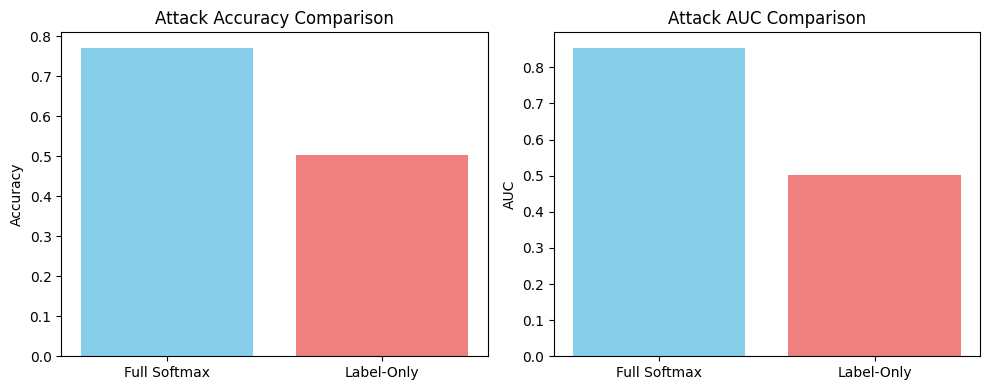

In [53]:
import matplotlib.pyplot as plt

# 📚 First run Full Softmax Attack for comparison
print("\n======== Running Full Softmax Attack ========")
attack_train_X, attack_train_Y, attack_test_X, attack_test_Y = prepare_attack_data(precision=None, label_only=False)

attack_train_loader = build_attack_loader(attack_train_X, attack_train_Y)
attack_test_loader = build_attack_loader(attack_test_X, attack_test_Y, shuffle=False)

attack_model_full = train_attack_model(attack_train_loader, input_dim=attack_train_X.shape[1], epochs=30)
full_acc, full_auc = evaluate_attack_model(attack_model_full, attack_test_loader, return_metrics=True)

# 📚 Now run Label-Only Attack
print("\n======== Running Label-Only Attack ========")
attack_train_X_labelonly, attack_train_Y_labelonly, attack_test_X_labelonly, attack_test_Y_labelonly = prepare_attack_data(label_only=True)

attack_train_loader_labelonly = build_attack_loader(attack_train_X_labelonly, attack_train_Y_labelonly)
attack_test_loader_labelonly = build_attack_loader(attack_test_X_labelonly, attack_test_Y_labelonly, shuffle=False)

attack_model_labelonly = train_attack_model(attack_train_loader_labelonly, input_dim=attack_train_X_labelonly.shape[1], epochs=30)
labelonly_acc, labelonly_auc = evaluate_attack_model(attack_model_labelonly, attack_test_loader_labelonly, return_metrics=True)

# 📈 Plot comparison
labels = ['Full Softmax', 'Label-Only']
accs = [full_acc, labelonly_acc]
aucs = [full_auc, labelonly_auc]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(labels, accs, color=['skyblue', 'lightcoral'])
plt.title("Attack Accuracy Comparison")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.bar(labels, aucs, color=['skyblue', 'lightcoral'])
plt.title("Attack AUC Comparison")
plt.ylabel("AUC")

plt.tight_layout()
plt.show()


In [37]:
# 🛠️ Generate Attack Data
attack_train_X, attack_train_Y, attack_test_X, attack_test_Y = prepare_attack_data()

# 🛠️ Build loaders
attack_train_loader = build_attack_loader(attack_train_X, attack_train_Y)
attack_test_loader = build_attack_loader(attack_test_X, attack_test_Y, shuffle=False)

# 🚀 Train Attack Model
attack_model = train_attack_model(attack_train_loader, input_dim=attack_train_X.shape[1])

# 🧪 Evaluate
evaluate_attack_model(attack_model, attack_test_loader)



Training Target Model...
Epoch 0, Train Loss: 142.2307
Epoch 10, Train Loss: 23.6103
Epoch 20, Train Loss: 1.2175
Epoch 30, Train Loss: 0.3785
Epoch 40, Train Loss: 0.1740
Epoch 50, Train Loss: 0.0935
Epoch 60, Train Loss: 0.0540
Epoch 70, Train Loss: 0.0328
Test Accuracy: 0.6239
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1044
           1       0.72      0.69      0.71      1057
           2       0.52      0.51      0.52      1092
           3       0.45      0.42      0.44      1015
           4       0.55      0.54      0.54      1050
           5       0.55      0.54      0.54      1050
           6       0.69      0.72      0.71      1050
           7       0.65      0.70      0.67      1052
           8       0.74      0.75      0.75      1083
           9       0.66      0.69      0.68      1027

    accuracy                           0.62     10520
   macro avg       0.62      0.62      0.62     10520
weighted avg  


======== Running for precision: None ========

Training Target Model...
Epoch 0, Train Loss: 145.2158
Epoch 10, Train Loss: 28.8460
Epoch 20, Train Loss: 1.5401
Epoch 30, Train Loss: 0.4441
Epoch 40, Train Loss: 0.2031
Epoch 50, Train Loss: 0.1073
Epoch 60, Train Loss: 0.0616
Epoch 70, Train Loss: 0.0370
Test Accuracy: 0.6225
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1039
           1       0.74      0.71      0.73      1100
           2       0.49      0.51      0.50      1041
           3       0.47      0.47      0.47      1029
           4       0.58      0.53      0.55      1083
           5       0.53      0.47      0.50      1031
           6       0.68      0.70      0.69      1073
           7       0.67      0.69      0.68      1049
           8       0.72      0.74      0.73      1025
           9       0.67      0.72      0.69      1050

    accuracy                           0.62     10520
   macro avg       0.

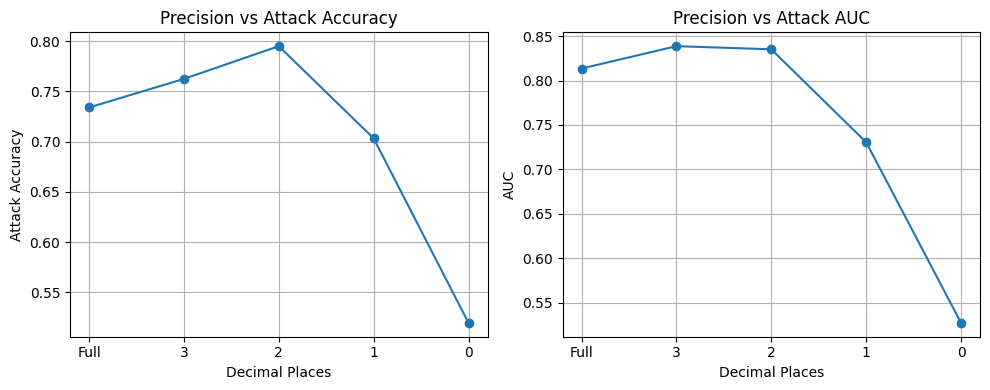

In [49]:
import matplotlib.pyplot as plt

precisions = [None, 3, 2, 1, 0]
attack_accuracies = []
attack_aucs = []

for p in precisions:
    print(f"\n======== Running for precision: {p} ========")
    attack_train_X, attack_train_Y, attack_test_X, attack_test_Y = prepare_attack_data(precision=p)
    attack_train_loader = build_attack_loader(attack_train_X, attack_train_Y)
    attack_test_loader = build_attack_loader(attack_test_X, attack_test_Y, shuffle=False)

    attack_model = train_attack_model(attack_train_loader, input_dim=attack_train_X.shape[1], epochs=50)
    model_acc, model_auc = evaluate_attack_model(attack_model, attack_test_loader, return_metrics=True)

    attack_accuracies.append(model_acc)
    attack_aucs.append(model_auc)

# 📈 Plot Results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(['Full', 3, 2, 1, 0], attack_accuracies, marker='o')
plt.title("Precision vs Attack Accuracy")
plt.xlabel("Decimal Places")
plt.ylabel("Attack Accuracy")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(['Full', 3, 2, 1, 0], attack_aucs, marker='o')
plt.title("Precision vs Attack AUC")
plt.xlabel("Decimal Places")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()
